# Sentiment Analysis con BERT

En este notebook se propone una implementación de BERT (*Bidirectional Encoder Representations from Transformers*) para atacar un problema de *sentiment analysis* sobre un set de datos de revisión de *apps* de Google.

### Librerías

In [1]:
!pip install transformers --quiet

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow
from transformers import TFBertModel

2024-06-29 21:16:28.887377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 21:16:28.887475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 21:16:29.061087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Modelo

In [2]:
max_length = 140
output_shape = 5

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
dense = tensorflow.keras.layers.Dense(output_shape, activation='relu')(x)
#dense_dropout = tensorflow.keras.layers.Dropout(0.2)(dense)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(dense)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.F1Score(average='macro')])

def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count, y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count, y=history.history['val_accuracy'], label='valid')
    plt.show()

model.summary()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

### Carga de datos y análisis exploratorio

In [3]:
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

df = pd.read_csv('reviews.csv')
df.head()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0   202k      0 --:--:-- --:--:-- --:--:--  202k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7002k  100 7002k    0     0   323k      0  0:00:21  0:00:21 --:--:-- 1614k


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [5]:
df['score'] = df['score'].apply(lambda x: x - 1)
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,0,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,0,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,0,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",0,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,0,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


<Axes: xlabel='score', ylabel='count'>

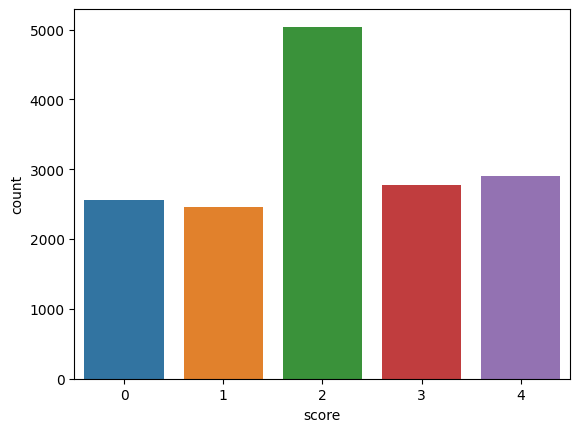

In [6]:
sns.countplot(x=df['score'])

### Limpieza de datos

In [7]:
# Balancear los datos
# subsample_count = df['score'].value_counts().min()
# df = df.groupby('score').apply(lambda x: x.sample(n=subsample_count, random_state=1)).reset_index(drop=True)

In [8]:
# ax = sns.countplot(df, x='score')
# plt.xlabel('review score')
# plt.show()

In [9]:
sentences = df['content'].values
print('sentences shape:', sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


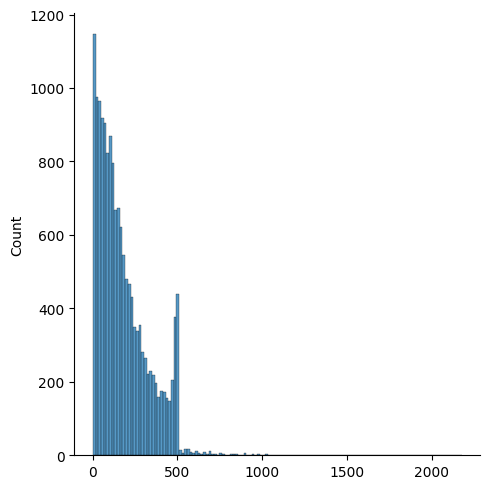

In [10]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print('Median:', np.median(sentence_lens))
sns.displot(sentence_lens)

In [11]:
from tensorflow.keras.utils import to_categorical

y = df['score'].values
print('y shape:', y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print('output shape:', output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


### Data generator

In [12]:
from transformers import InputExample, InputFeatures, BertTokenizer

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Del dataset original accederemos a los datos por índices (idx) mezclados aleatoriamente
max_length = 140 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

print('idx_train shape', idx_train.shape[0])
print('idx_val shape', idx_val.shape[0])
print('idx_test shape', idx_test.shape[0])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

idx_train shape 10076
idx_val shape 2520
idx_test shape 3150


In [13]:

def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict['input_ids'], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    'input_ids': f.input_ids,
                    'attention_mask': f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({'input_ids': tensorflow.int32, 'attention_mask': tensorflow.int32}, tensorflow.float32),
        (
            {
                'input_ids': tensorflow.TensorShape([None]),
                'attention_mask': tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [14]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

X_test = [tf_batch['input_ids'], tf_batch['attention_mask']]
y_test = y[idx_test]

### BERT multiclass classification

In [15]:
y_test.shape

(3150, 5)

In [16]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['score']), y=df['score'])
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.2272798129384255, 1: 1.2791226645004061, 2: 0.6245934153113843, 3: 1.1344380403458214, 4: 1.0859310344827586}


In [17]:
history = model.fit(train_data, epochs=20, validation_data=validation_data)#, class_weight=class_weights_dict)

Epoch 1/20


I0000 00:00:1719695927.442913     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 [==============================] - 180s 415ms/step - loss: 1.5804 - accuracy: 0.3202 - f1_score: 0.1018 - val_loss: 1.5521 - val_accuracy: 0.3190 - val_f1_score: 0.0968
Epoch 2/20
315/315 [==============================] - 123s 391ms/step - loss: 1.5592 - accuracy: 0.3234 - f1_score: 0.0978 - val_loss: 1.5357 - val_accuracy: 0.3190 - val_f1_score: 0.0968
Epoch 3/20
315/315 [==============================] - 126s 400ms/step - loss: 1.5421 - accuracy: 0.3234 - f1_score: 0.0978 - val_loss: 1.5182 - val_accuracy: 0.3190 - val_f1_score: 0.0968
Epoch 4/20
315/315 [==============================] - 126s 400ms/step - loss: 1.5192 - accuracy: 0.3626 - f1_score: 0.1843 - val_loss: 1.5067 - val_accuracy: 0.4040 - val_f1_score: 0.2179
Epoch 5/20
315/315 [==============================] - 126s 400ms/step - loss: 1.4977 - accuracy: 0.3755 - f1_score: 0.1955 - val_loss: 1.4770 - val_accuracy: 0.4075 - val_f1_score: 0.2202
Epoch 6/20
315/315 [==============================] - 126s 400ms/step -

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

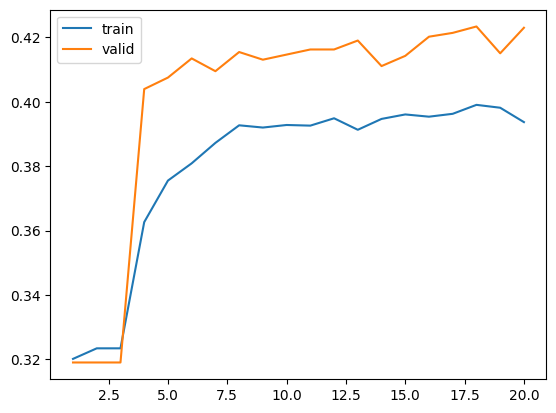

In [18]:
plot_train_metrics(history)

In [19]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 41s 304ms/step


array([[0.24540627, 0.2231522 , 0.39350897, 0.11270761, 0.02522487],
       [0.18532906, 0.18087026, 0.38535523, 0.17365919, 0.07478623],
       [0.143612  , 0.14677651, 0.35380298, 0.21432279, 0.14148569]],
      dtype=float32)

In [20]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [21]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 41s 305ms/step - loss: 1.3473 - accuracy: 0.4013 - f1_score: 0.2258


0.4012698531150818

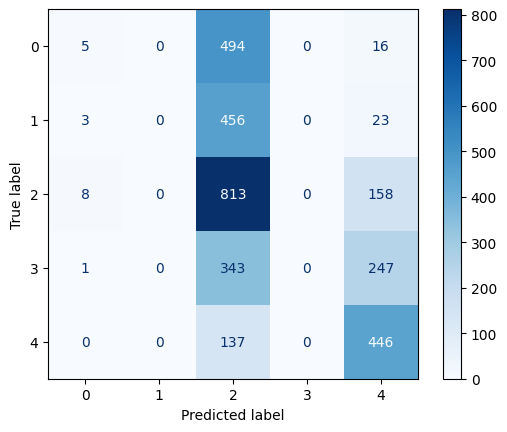

In [22]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

### Realizar predicciones

In [23]:
text = 'I love this app!'

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print('Inputs ids:', tf_batch['input_ids'])
print('Attention mask:', tf_batch['attention_mask'])


Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [24]:
X_ensayo = [tf_batch['input_ids'], tf_batch['attention_mask']]

y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print('Clasificación:', int(y_prob))

1/1 [==============================] - 0s 64ms/step
Clasificación: 4


/tmp/ipykernel_34/4193972220.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Clasificación:', int(y_prob))


In [25]:
text = 'I don\'t hate it. It\'s good anough'

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print('Inputs ids:', tf_batch['input_ids'])
print('Attention mask:', tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[  101  1045  2123  1005  1056  5223  2009  1012  2009  1005  1055  2204
   2019 10593   102     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 

In [26]:
X_ensayo = [tf_batch['input_ids'], tf_batch['attention_mask']]

y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print('Clasificación:', int(y_prob))

1/1 [==============================] - 0s 56ms/step
Clasificación: 2


/tmp/ipykernel_34/4193972220.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Clasificación:', int(y_prob))


In [31]:
text = 'Just can\'t stand it'

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print('Inputs ids:', tf_batch['input_ids'])
print('Attention mask:', tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[ 101 2074 2064 1005 1056 3233 2009  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [32]:
X_ensayo = [tf_batch['input_ids'], tf_batch['attention_mask']]

y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print('Clasificación:', int(y_prob))

1/1 [==============================] - 0s 54ms/step
Clasificación: 2


/tmp/ipykernel_34/4193972220.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Clasificación:', int(y_prob))
